### Batches, Batch Normalization and Dropout

In this workbook you can experiment what you learnt about how to make batches out of your data, how to perform batch normalization and dropout

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Load the data from data/batches_norm_drop.csv, then take a look at them.

In [2]:
# YOUR CODE HERE
data = pd.read_csv(r'D:\DATASCIENCE\DeepLearning-DS\Chapter 03\04. DataLoader\data\batches_norm_drop.csv', header=None)


In [3]:
data

,0,1,2
0,0.350140,4.248592,0
1,0.950728,3.528855,0
2,1.371517,3.149416,0
3,0.268221,4.337209,0
4,1.881996,1.515387,0
...,...,...,...
745,-3.425455,3.349783,2
746,-1.513002,2.789840,2
747,-1.070356,3.484981,2
748,-2.970848,3.443924,2


In [6]:
x = data.iloc[:,:-1].values
y = data.iloc[:,-1].values

AttributeError: 'numpy.ndarray' object has no attribute 'unique'

In [8]:
from sklearn.model_selection import train_test_split
import torch

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.1, random_state = 0)

x_train = torch.tensor(x_train.astype(np.float32))
x_test = torch.tensor(x_test.astype(np.float32))

y_train = torch.tensor(y_train.astype(np.float32))
y_test = torch.tensor(y_test.astype(np.float32))

Now you are ready to code your own function to create batches. If needed rewatch the video we provided in Eduflow.

**Extra challange:**    Are you able to split between train and test _**without**_ using sklearn?

In [9]:
def batchify(x_train, x_test, y_train, y_test, batch_size):
#YOUR CODE HERE
    n_batches = x_train.shape[0] // batch_size # 11 / 3 = 3.66 -> 3
    n_batches_test = x_test.shape[0] // batch_size

    indexes = np.random.permutation(x_train.shape[0])
    indexes_test = np.random.permutation(x_test.shape[0])


    x_train = x_train[indexes]
    y_train = y_train[indexes]

    x_test = x_test[indexes_test]
    y_test = y_test[indexes_test]

    x_train = x_train[ :batch_size * n_batches ].reshape(n_batches, batch_size, x_train.shape[1])
    y_train = y_train[ :batch_size * n_batches ].reshape(n_batches, batch_size, 1)
    
    x_test = x_test[ :batch_size * n_batches_test ].reshape(n_batches_test, batch_size, x_test.shape[1])
    y_test = y_test[ :batch_size * n_batches_test ].reshape(n_batches_test, batch_size, 1)


    return x_train, x_test, y_train, y_test    


It's time to create your model! Remember to include the new tricks you learnt (batch normalization and dropout)!

In [25]:
# YOUR CODE HERE

import torch.nn.functional as F
from torch import nn
class Classify(nn.Module):
    def __init__(self):
        super(Classify, self).__init__()
        self.input_layer = nn.Linear(2, 56)
        self.batchnorm = nn.BatchNorm1d(56) # applying batch norm 
        self.hidden1 = nn.Linear(56, 49)
        self.drop = nn.Dropout(0.1) 
        self.hidden2 = nn.Linear(49, 8) 
        self.output = nn.Linear(8, 3)
    
    def forward(self, x):
        first_layer = self.input_layer(x)
        act1 = F.relu(first_layer)
        second_layer = self.hidden1(act1)
        act2 = F.relu(second_layer)
        third_layer = self.hidden2(act2)
        act3 = F.relu(third_layer)
        out_layer = self.output(act3)
        x = F.softmax(out_layer)
        return out_layer


Train your model and evaluate it. **Extra challenge**: try to figure out how you can tell if batch norm and dropout are effective

C:\Anaconda\envs\strive\lib\site-packages\ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch: 1 | loss: 1.5410572290420532 | test loss: 1.7179533243179321
Epoch: 1 | loss: 1.9332613945007324 | test loss: 1.7133086919784546
Epoch: 1 | loss: 2.382766008377075 | test loss: 1.7076481580734253
Epoch: 1 | loss: 1.686457872390747 | test loss: 1.7030812501907349
Epoch: 1 | loss: 1.787933588027954 | test loss: 1.6977607011795044
Epoch: 1 | loss: 1.966483473777771 | test loss: 1.6934256553649902
Epoch: 1 | loss: 2.175502300262451 | test loss: 1.6877787113189697
Epoch: 1 | loss: 1.8532322645187378 | test loss: 1.682885766029358
Epoch: 1 | loss: 1.805775761604309 | test loss: 1.6779247522354126
Epoch: 1 | loss: 1.3539459705352783 | test loss: 1.6742123365402222
Epoch: 1 | loss: 1.3890548944473267 | test loss: 1.6707489490509033
Epoch: 1 | loss: 1.995659351348877 | test loss: 1.666052222251892
Epoch: 1 | loss: 1.7342387437820435 | test loss: 1.6621406078338623
Epoch: 1 | loss: 0.7842833995819092 | test loss: 1.6598368883132935
Epoch: 1 | loss: 1.9953714609146118 | test loss: 1.654881

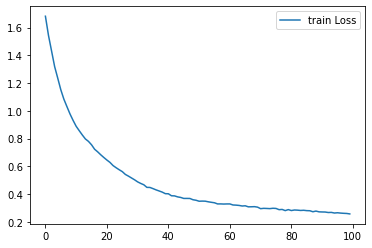

In [26]:
# YOUR CODE HERE
import torch.optim as optim

model = Classify()

epochs = 100


criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=1e-3)

loss_train = []
loss_test = []


for epoch in range(epochs):

    running_train_loss = 0
    running_test_loss = 0

    x_trbh, x_tsbh, y_trbh, y_tsbh = batchify(x_train, x_test, y_train, y_test, 20)
    for i in range(x_trbh.shape[0]):
        

        optimizer.zero_grad()
        pred=model.forward(x_trbh[i])
        train_loss=criterion(pred,y_trbh[i])
        train_loss.backward()
        optimizer.step()


        model.eval()
        with torch.no_grad():

            test_pred = model.forward(x_tsbh)

            test_loss = criterion(test_pred, y_tsbh)


        model.train()

        running_train_loss += train_loss.item()
        running_test_loss += test_loss.item()

        #loss_train.append(train_loss.item())
        #loss_test.append(test_loss.item())
       
        print(f'Epoch: {epoch + 1} | loss: {train_loss.item()} | test loss: {test_loss.item()}' )

    loss_train.append(running_train_loss/len(x_trbh))
    loss_test.append(running_test_loss/len(x_tsbh))

plt.plot(loss_train, label='train Loss')
#plt.plot(loss_test, label='test Loss')

plt.legend()
plt.show()
